# Reproduce Figures
1. Coverage vs. Atypicality Quantile, for any experimental setting
2. Coefficients $\beta$ for 3x3 Experimental Settings Using Atypicality 
3. Mean Coverage, Mean $\beta$, and Mean MSE from the Mean for values of $\lambda$
4. Coverage vs. Beta for values of $\lambda$


In [1]:
import sys
sys.path.append("../src")

from atypicality import compute_atypicality_scores
from data_generation_settings import split_and_scale_data, generate_and_split_mvn_data, generate_and_split_lognormal_data, generate_and_split_gmm_data, load_and_split_hf_data, load_and_split_support_data
from fit_cp_models import fit_rf_cp_model, fit_gaussian_cp_model, fit_conformal_cp_model
from compute_bounds import evaluate_lambda_adjusted_interval_coverage
from compute_betas import compute_beta
from lambda_tuning import run_lambda_selection_and_evaluation
from plotting import plot_coverage_across_atypicality_quantile, plot_betagrouped_by_atypicality, plot_lambda_metrics

# 1. Calculating Coverage vs. Atypicality Quantile for any experimental setting
Generate a plot of coverage across atypicality quantile. The `evaluate_lambda_adjusted_interval_coverage` function creates a dataframe with coverage for each quantile and specified experimental settings. The `plot_coverage_across_atypicality_quantile` filters the dataframe by specified `atypicality_score` and plots coverage across quantiles for different $\lambda$ values. 

* In `atypicality_settings`, specify which atypicality scores to use: `knn_score`, `kde_score`, `logjointmvn_score`, `lognormal_score`, and `gmm_score`. For each score, specify a corresponding $\lambda$ value by which to adjust the bounds. Recall that the `lognormal_score` assumes positive target y; make sure to only use the `lognormal_score` in the `generate_and_split_lognormal_data` data gneration setting or else the function will return an error.
* Specify which data generation setting to use: `generate_and_split_mvn_data`, `generate_and_split_lognormal_data`, and `generate_and_split_gmm_data`.
* Specify which conformal prediction algorithm to use: `fit_rf_cp_model`, `fit_gaussian_cp_model`, `fit_conformal_cp_model`
* When `true_atypicality=True`, we use the true atypicality value. When `true_atypicality=False`, we use the predicted atypicality value.
* When `return_df=True`, the second value of the returned tuple will contain predictions, lower and upper intervals generated by the CP algorithm, and adjusted intervals according to $\lambda$. 
* `silent` mutes print statements from the internal functions, reporting status. 

In our paper, we use `n_samples = 5000`, `n_splits=5`, and `num_quantiles = 5`. 

In [ ]:
atypicality_settings = [
    ('logjointmvn_score', 0),
    ('logjointmvn_score', 1)
]

# Run calibration across all atypicality types
coverage_by_quantile_lambda, df = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=generate_and_split_mvn_data, 
                                        fit_cp_model=fit_conformal_cp_model, 
                                        n_samples=5000,
                                        n_splits=5, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        return_df=True,
                                        silent=True)

# Peek at output: coverage across atypicality score, quantile, split, and lambda
coverage_by_quantile_lambda.head(5)

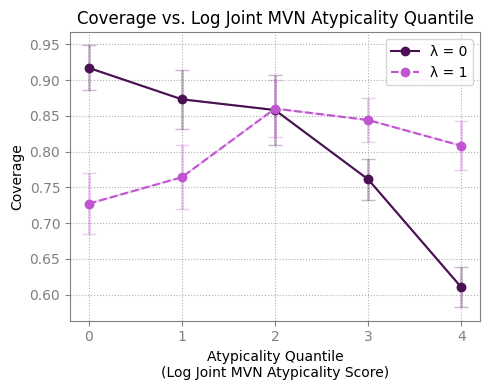

In [ ]:
# Plot result for a specific atypicality score
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)

# 2. Calculate $\beta$ for 3x3 Experimental Settings Using Atypicality
Our paper demonstreates the utility of atypicality by calculating the coefficient for coverage vs. atypicality quantile across several data generation settings, conformal prediction algorithms, and atypicality scores. The following code uses `compute_beta` to regenerate the figure, iterating across all experimental settings. 

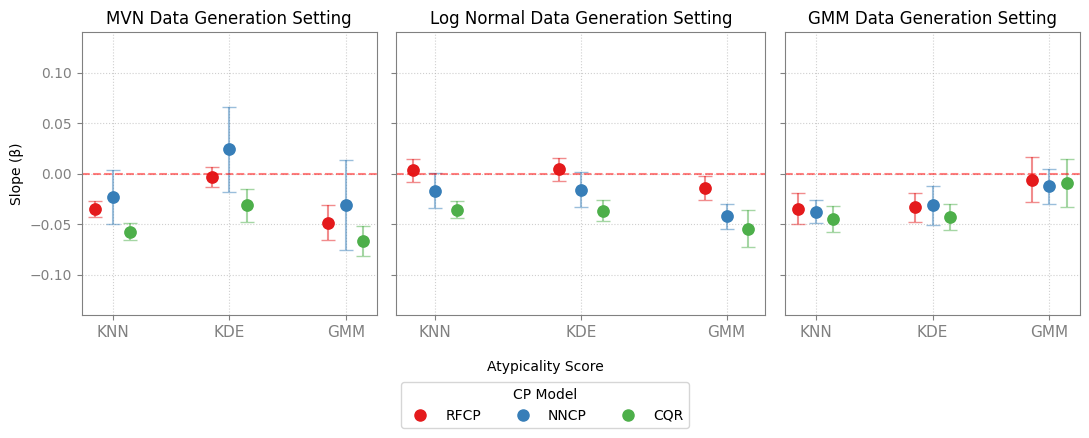

In [ ]:
beta_df = compute_beta(true_atypicality=True, silent=True)
# Took 29 min to run. 
plot_betagrouped_by_atypicality(beta_df=beta_df, true_atypicality=True, outputfile="3x3_atypicality.png")

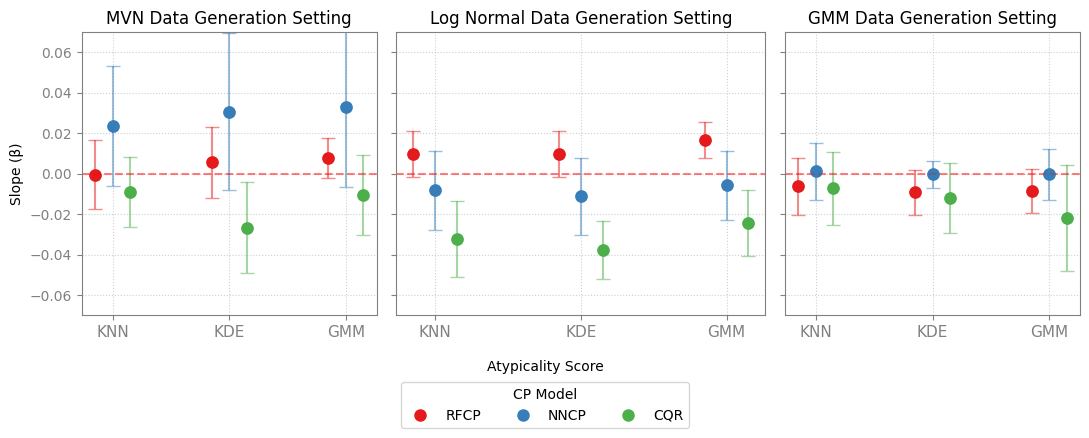

In [ ]:
beta_df = compute_beta(true_atypicality=False, silent=True)
# Took 15 min to run. 
plot_betagrouped_by_atypicality(beta_df=beta_df, 
                                true_atypicality=False, 
                                outputfile="3x3_predicted_atypicality.png")

In [9]:
beta_df

,Data Generation Setting,CP Model,Atypicality Score,Lambda,Mean Beta,Std Beta,CP Model Label,Data Generation Label,Atypicality Label
0,generate_and_split_mvn_data,fit_rf_cp_model,gmm_score,0,0.00775,0.010093,RFCP,MVN Data Generation Setting,GMM
1,generate_and_split_mvn_data,fit_rf_cp_model,kde_score,0,0.00575,0.017558,RFCP,MVN Data Generation Setting,KDE
2,generate_and_split_mvn_data,fit_rf_cp_model,knn_score,0,-0.00050,0.017016,RFCP,MVN Data Generation Setting,KNN
3,generate_and_split_mvn_data,fit_rf_cp_model,logjointmvn_score,0,0.00775,0.020027,RFCP,MVN Data Generation Setting,Log Joint MVN
4,generate_and_split_mvn_data,fit_gaussian_cp_model,gmm_score,0,0.03325,0.039859,NNCP,MVN Data Generation Setting,GMM
5,generate_and_split_mvn_data,fit_gaussian_cp_model,kde_score,0,0.03075,0.038696,NNCP,MVN Data Generation Setting,KDE
6,generate_and_split_mvn_data,fit_gaussian_cp_model,knn_score,0,0.02350,0.029652,NNCP,MVN Data Generation Setting,KNN
7,generate_and_split_mvn_data,fit_gaussian_cp_model,logjointmvn_score,0,0.03425,0.041978,NNCP,MVN Data Generation Setting,Log Joint MVN
8,generate_and_split_mvn_data,fit_conformal_cp_model,gmm_score,0,-0.01050,0.019697,CQR,MVN Data Generation Setting,GMM
9,generate_and_split_mvn_data,fit_conformal_cp_model,kde_score,0,-0.02675,0.022441,CQR,MVN Data Generation Setting,KDE


# 3 & 4. Performance metrics and Coverage vs. Beta for values of $\lambda$ 
* different metrics for different values of $\lambda$.
* Coverage vs. beta for different values of $\lambda$. 
* Distribution of relative position of points within the interval.

Things to check:
1. Calibration for $\lambda$ does not use data that was already used to train
2. Change graph to be more aesthetically appealing
3. Change graphs above as well to be more sighlty
4. do I want to allow users to specify how many steps of lambda are tested? how many n_samples? make the inputs into lambda_hyperparameter_tuning more similar to evaluate_...? 

For the specified atypicality score `atyp_col`, the function `lambda_hyperparameter_tuning` will calculate performance metrics on `y_test`. 
* When `hyperparamter_tuning=True`, the function treats `y_test` like a second calibration set to choose $\lambda$. If `hyperparamter_tuning=False`, then we generate entirely new data on which to calculate coverage for $\lambda$, using offset random seeds. This ensures no data leakage between hyperparameter tuning and evaluation.

It returns the following objects: 
* `lambda_metrics` is a dictionary, where each key refers to a $\lambda$ value and each value refers to a dataframe containing performance metrics
* `lambda_results` is a dataframe of point predictions and $\lambda$-adjusted bounds
* `merged_dfs` is a dictionary, where each key refers to a $\lambda$ value and each value refers to dataframe containing the coverage across atypicality quantile

Fit CQR!


320it [00:02, 148.65it/s]
400it [00:02, 146.79it/s]


Test!
y_test: (400,)
y_pred: (400, 2)
y_lower: (400,)
y_upper: (400,)
scores: (400,)
Fit CQR!


320it [00:02, 152.86it/s]
400it [00:02, 156.67it/s]


Test!
y_test: (400,)
y_pred: (400, 2)
y_lower: (400,)
y_upper: (400,)
scores: (400,)
Lambda with highest overall coverage: logjointmvn_score_lam0-75 with coverage 0.81875
Lambda with coefficients closest to 0: logjointmvn_score_lam0-75 with coefficient value -0.0024999999999999966
Lambda with lowest MSE: logjointmvn_score_lam0-75 with MSE 0.0007437500000000007


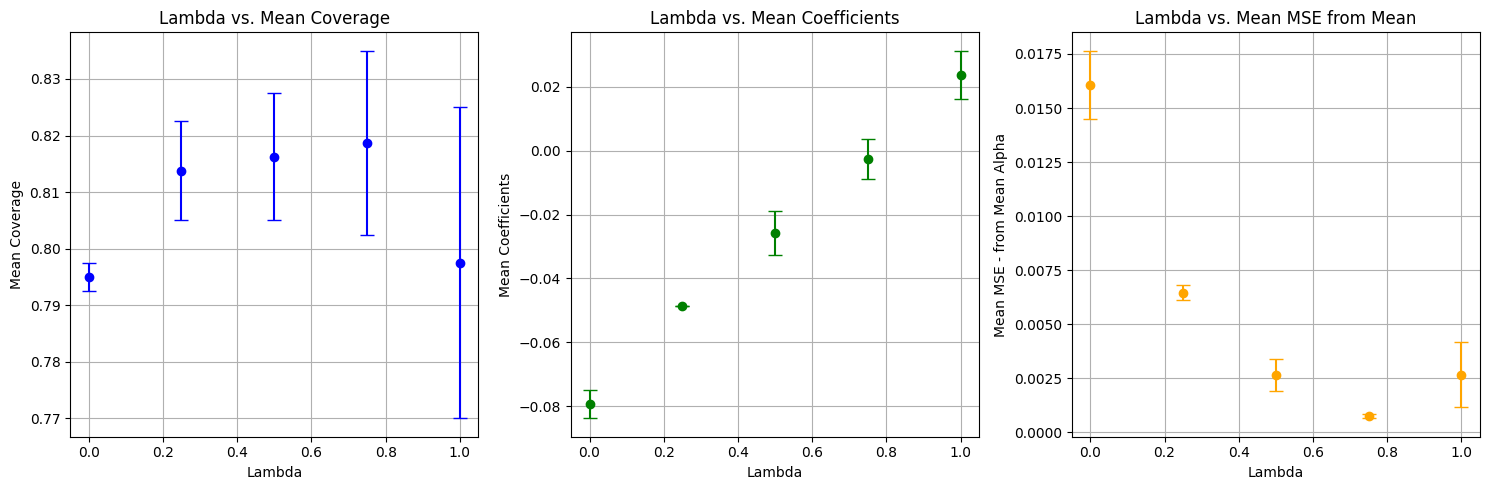

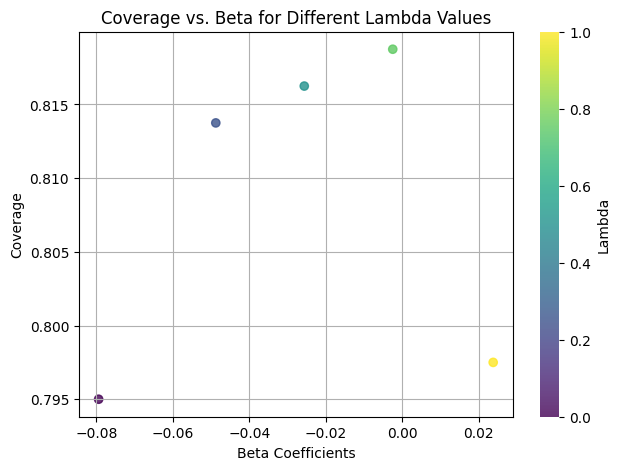

In [2]:
lambda_metrics, lambda_results, merged_dfs = lambda_hyperparameter_tuning(atyp_col='logjointmvn_score', 
                                                            make_and_split_data=generate_and_split_mvn_data, 
                                                            fit_cp_model=fit_conformal_cp_model, 
                                                            n_splits=2, 
                                                            true_atypicality=True, 
                                                            hyperparameter_tuning=True)
plot_lambda_metrics(lambda_metrics)

In the following code, we use the `lambda_hyperparameter_tuning` with `hyperparamter_tuning=True` to select the best $\lambda$ value. Then, we can evaluate coverage using the best $\lambda$ value on new data. 

In [ ]:
# Function to iterate through the atypicality scores, find the best lambda, and return relevant metrics. 
# atyp_scores = ['knn_score', 'kde_score', 'log_joint_mvn_score', 'gmm_score', 'lognormal_score']
# data_generation_settings = [generate_and_split_mvn_data, generate_and_split_lognormal_data, generate_and_split_gmm_data]
# cp_models = [fit_rf_cp_model, fit_gaussian_cp_model, fit_conformal_cp_model]

atyp_scores = ['knn_score', 'kde_score']
data_generation_settings = [generate_and_split_mvn_data]
cp_models = [fit_rf_cp_model, fit_conformal_cp_model]
true_atypicality = True
n_splits = 1

lambda_metric_results, coverage_results = run_lambda_selection_and_evaluation(atyp_scores, 
                                                                              data_generation_settings, 
                                                                              cp_models, 
                                                                              n_splits, 
                                                                              true_atypicality)

Lambda with highest overall coverage: knn_score_lam1-0 with coverage 0.8675
Lambda with coefficients closest to 0: knn_score_lam0-5 with coefficient value 0.005000000000000005
Lambda with lowest MSE: knn_score_lam0-5 with MSE 0.00024999999999999935
Lambda with highest overall coverage: knn_score_lam0-0 with coverage 0.8025
Lambda with coefficients closest to 0: knn_score_lam0-5 with coefficient value 0.02375000000000002
Lambda with lowest MSE: knn_score_lam0-5 with MSE 0.002562500000000001
Lambda with highest overall coverage: knn_score_lam0-75 with coverage 0.7975
Lambda with coefficients closest to 0: knn_score_lam0-75 with coefficient value 0.011250000000000008
Lambda with lowest MSE: knn_score_lam0-75 with MSE 0.0009624999999999984
Lambda with highest overall coverage: knn_score_lam0-75 with coverage 0.8299999999999998
Lambda with coefficients closest to 0: knn_score_lam0-75 with coefficient value 0.013749999999999998
Lambda with lowest MSE: knn_score_lam0-75 with MSE 0.00141249999

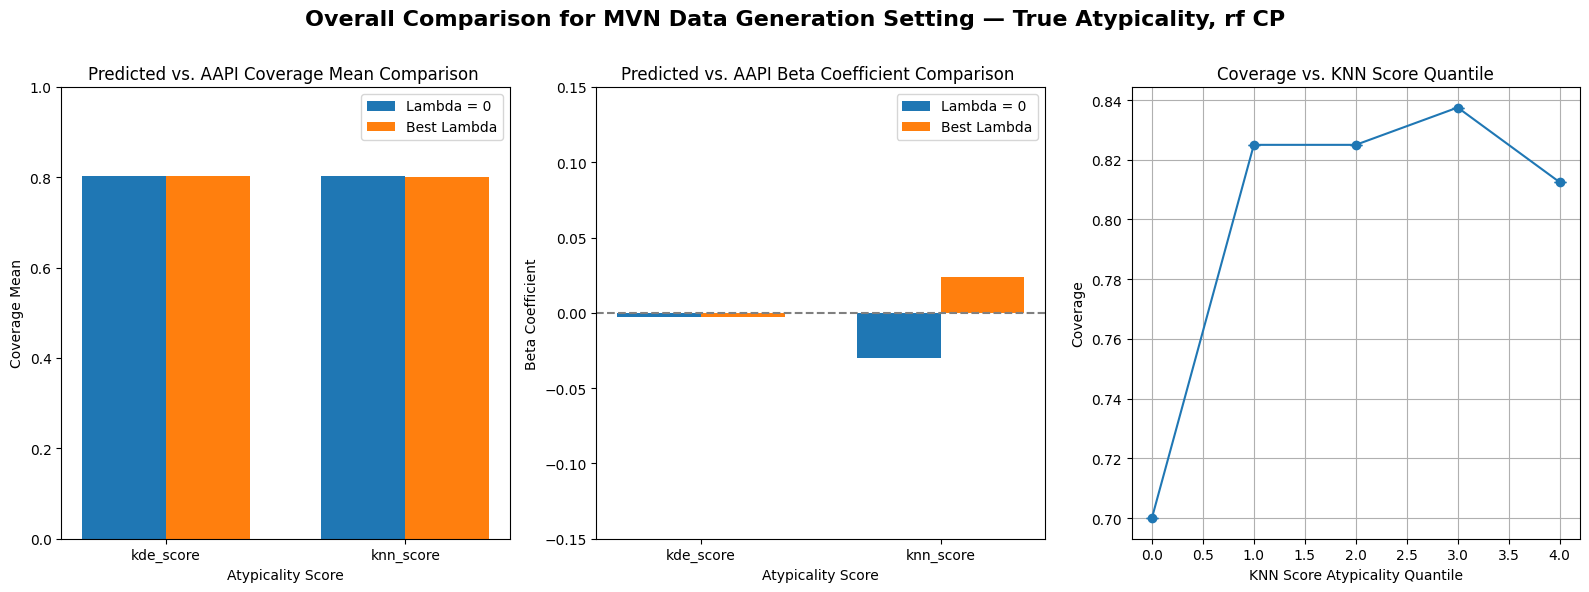

In [5]:
# atyp_scores = ['knn_score']
# data_generation_settings = [generate_and_split_mvn_data]
# cp_models = [fit_rf_cp_model]

from plotting import plot_datagen_lambda_comparison

plot_datagen_lambda_comparison(lambda_metric_results, 
                               coverage_results,
                               atyp_col = 'knn_score',
                               atypicality_score_title = 'KNN Score',
                               data_generation_setting = generate_and_split_mvn_data,
                               data_generation_setting_title = 'MVN Data Generation Setting',
                               cp_model = fit_rf_cp_model,
                               atypicality_scores = ['knn_score', 'kde_score', 
                                                        'log_joint_mvn_score', 'lognormal_score',
                                                        'gmm_score'],
                               true_atypicality = True)

Next:
* change color of plots - use colab v4 to update the right-most plot of this graph with colors
* change the size of plots to fit the paper

# Implement Real-world analysis of Atypicality
The atypicality scores do not make assumptions about the number of features!

In [ ]:
atypicality_settings = [
    ('gmm_score', 0),
    ('gmm_score', 1)
]

# Run calibration across all atypicality types
coverage_by_quantile_lambda, _ = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_support_data, 
                                        fit_cp_model=fit_gaussian_cp_model, 
                                        n_samples=500, # Number of samples is ignored; real dataset is of fixed size
                                        n_splits=3, 
                                        true_atypicality=False,
                                        num_quantiles=5,
                                        return_df=False,
                                        silent=True)

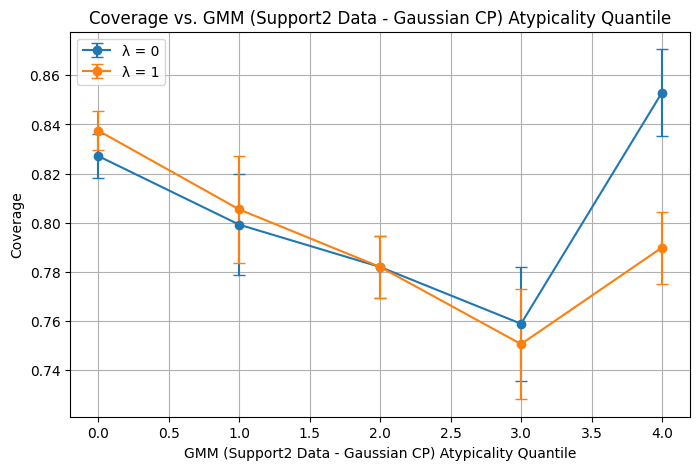

In [22]:
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "gmm_score",
                                          atypicality_score_title="GMM (Support2 Data - Gaussian CP)",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)

In [23]:
coverage_by_quantile_lambda.to_csv('eval_lambda01_gmm_support2_gaussiancp.csv')

In [ ]:
coverage_by_quantile_lambda,_ = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_support_data, 
                                        fit_cp_model=fit_gaussian_cp_model, 
                                        n_samples=500, # Number of samples is ignored; real dataset is of fixed size
                                        n_splits=3, 
                                        true_atypicality=False,
                                        num_quantiles=5,
                                        return_df=False,
                                        silent=True)

# Generating Teaser Figure
3 sub-figures to show:
1. atypicality is correlated with lower coverage (beta is negative)
2. atypicality overlaps with underrepresented demographic groups
3. there are points that are in represented groups that are atypical and have low-coverage

- using SUPPORT2 data + logjointmvn score

First: check if SUPPORT2 is MVN.

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
def load_and_split_support_numeric_data(random_seed, test_size=0.2, calib_size=0.2, n_samples=None):
    df_support2 = pd.read_csv('../data/support2.csv')

    # Drop if race or sfdm2 is na
    df_support2 = df_support2.dropna(subset=['race', 'sfdm2'])

    # Drop previous models' recommendations (suggested by data doc)
    leaky_vars_to_drop = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
    df_support2.drop(columns=leaky_vars_to_drop, inplace=True)
    
    # Drop rows with 1 missing value
    missing_counts = df_support2.isnull().sum()
    columns_with_one_missing = missing_counts[missing_counts == 1].index.tolist()
    rows_to_drop_indices = []

    for col in columns_with_one_missing:
        row_index = df_support2[df_support2[col].isnull()].index[0]
        rows_to_drop_indices.append(row_index)
    df_support2.drop(list(set(rows_to_drop_indices)), inplace=True)

    # Drop columns with more than 50% missingness
    drop_cols = ['adlp', 'urine', 'glucose']
    df_support2.drop(columns=drop_cols, inplace=True)

    # Impute the numeric columns
    num_cols = df_support2.select_dtypes(include='number').columns.tolist()
    num_imputer = SimpleImputer(strategy='median')
    df_support2[num_cols] = num_imputer.fit_transform(df_support2[num_cols])

    # Drop categorical columns except for race and sfdm2
    cols_to_drop = ['ca', 'dzgroup', 'dzclass', 'sex', 'income', 'hospdead', 'diabetes', 'dementia', 'race']
    df_support2.drop(columns=cols_to_drop, inplace=True)

    # Map ordinal sfdm2
    sfdm2_mapping = {
        'no(M2 and SIP pres)': 1,
        'adl>=4 (>=5 if sur)': 2,
        'SIP>=30': 3,
        'Coma or Intub': 4,
        '<2 mo. follow-up': 5}
    df_support2['sfdm2'] = df_support2['sfdm2'].map(sfdm2_mapping)

    # One-hot encode race
    # df_support2 = pd.get_dummies(df_support2, columns=['race'], drop_first=False, dtype=int)

    # Add missingness flags
    for col in df_support2.columns:
        df_support2[col + '_missing'] = df_support2[col].isnull().astype(int)

    # Drop rows with 6 or more missing values
    missing_flag_cols = [c for c in df_support2.columns if c.endswith('_missing')]
    df_support2['num_missing'] = df_support2[missing_flag_cols].sum(axis=1)
    df_support2 = df_support2[df_support2['num_missing'] <= 6].copy()

    # Recompute numeric columns AFTER all transformations
    num_cols = df_support2.select_dtypes(include='number').columns.tolist()

    # Drop _missing and helper columns
    num_cols = [c for c in num_cols if not c.endswith('_missing') and c != 'num_missing']
    assert 'sfdm2' in num_cols
    df_support2 = df_support2[num_cols].copy()

    # Temporary sample of dataset to make it smaller
    df_support2 = df_support2.sample(n=2000, random_state=random_seed)

    # Split data
    X, y = df_support2.drop(columns=['sfdm2']).to_numpy(), df_support2['sfdm2'].to_numpy()
    X_fit, X_calib, X_test, y_fit, y_calib, y_test, scaler = split_and_scale_data(X, y, test_size, calib_size, random_seed)

    return X_fit, X_calib, X_test, y_fit, y_calib, y_test, scaler


atypicality_settings = [
    ('logjointmvn_score', 0),
    # ('logjointmvn_score', 0.5)
]

coverage_by_quantile_lambda, _ = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_support_numeric_data, 
                                        fit_cp_model=fit_conformal_cp_model, 
                                        n_samples=500, # Number of samples is ignored; real dataset is of fixed size
                                        n_splits=1, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        return_df=False,
                                        silent=True)

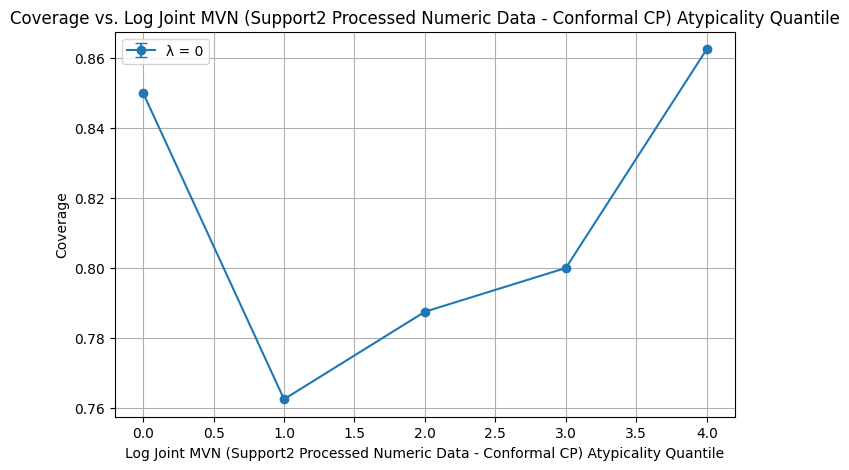

In [109]:
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN (Support2 Processed Numeric Data - Conformal CP)",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)

# Calculating df with atypicality and race

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

def split_and_scale_data_race(X, y, test_size, calib_size, random_seed, extra_arrays=None):
    if extra_arrays is None:
        extra_arrays = []

    # First split: train / test
    split_out = train_test_split(
        X, y, *extra_arrays,
        test_size=test_size,
        random_state=random_seed
    )

    X_train, X_test = split_out[0], split_out[1]
    y_train, y_test = split_out[2], split_out[3]

    n_extra = len(extra_arrays)
    extra_train = split_out[4 : 4 + n_extra]
    extra_test  = split_out[4 + n_extra :]

    # Second split: fit / calib (ONLY training extras)
    split_out = train_test_split(
        X_train, y_train, *extra_train,
        test_size=calib_size,
        random_state=random_seed
    )

    X_fit, X_calib = split_out[0], split_out[1]
    y_fit, y_calib = split_out[2], split_out[3]
    extra_fit_calib = split_out[4:]

    # Scale X only
    scaler = StandardScaler()
    X_fit = scaler.fit_transform(X_fit)
    X_calib = scaler.transform(X_calib)
    X_test = scaler.transform(X_test)

    return (
        X_fit, X_calib, X_test,
        y_fit, y_calib, y_test,
        *extra_fit_calib, *extra_test,
        scaler
    )

###
random_seed = 1
df_support2 = pd.read_csv('../data/support2.csv')

# Drop if race or sfdm2 is na
df_support2 = df_support2.dropna(subset=['race', 'sfdm2'])

# Drop previous models' recommendations (suggested by data doc)
leaky_vars_to_drop = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
df_support2.drop(columns=leaky_vars_to_drop, inplace=True)

# Drop rows with 1 missing value
missing_counts = df_support2.isnull().sum()
columns_with_one_missing = missing_counts[missing_counts == 1].index.tolist()
rows_to_drop_indices = []

for col in columns_with_one_missing:
    row_index = df_support2[df_support2[col].isnull()].index[0]
    rows_to_drop_indices.append(row_index)
df_support2.drop(list(set(rows_to_drop_indices)), inplace=True)

# Drop columns with more than 50% missingness
drop_cols = ['adlp', 'urine', 'glucose']
df_support2.drop(columns=drop_cols, inplace=True)

# Impute the numeric columns
num_cols = df_support2.select_dtypes(include='number').columns.tolist()
num_imputer = SimpleImputer(strategy='median')
df_support2[num_cols] = num_imputer.fit_transform(df_support2[num_cols])

# Drop categorical columns except for race and sfdm2
cols_to_drop = ['ca', 'dzgroup', 'dzclass', 'sex', 'income', 'hospdead', 'diabetes', 'dementia']
df_support2.drop(columns=cols_to_drop, inplace=True)

# Map ordinal sfdm2
sfdm2_mapping = {
    'no(M2 and SIP pres)': 1,
    'adl>=4 (>=5 if sur)': 2,
    'SIP>=30': 3,
    'Coma or Intub': 4,
    '<2 mo. follow-up': 5}
df_support2['sfdm2'] = df_support2['sfdm2'].map(sfdm2_mapping)

# One-hot encode race
# df_support2 = pd.get_dummies(df_support2, columns=['race'], drop_first=False, dtype=int)

# Add missingness flags
for col in df_support2.columns:
    df_support2[col + '_missing'] = df_support2[col].isnull().astype(int)

# Drop rows with 6 or more missing values
missing_flag_cols = [c for c in df_support2.columns if c.endswith('_missing')]
df_support2['num_missing'] = df_support2[missing_flag_cols].sum(axis=1)
df_support2 = df_support2[df_support2['num_missing'] <= 6].copy()

# Recompute numeric columns AFTER all transformations
num_cols = df_support2.select_dtypes(include='number').columns.tolist()

# Drop _missing and helper columns
num_cols = [c for c in num_cols if not c.endswith('_missing') and c != 'num_missing'] + ['race']
assert 'sfdm2' in num_cols
df_support2 = df_support2[num_cols].copy()

# Temporary sample of dataset to make it smaller
df_support2 = df_support2.sample(n=1000, random_state=random_seed)

# Split data
race = df_support2["race"].to_numpy()
df_support2.drop(columns=['race'], inplace=True)

feature_names = df_support2.drop(columns=['sfdm2']).columns.tolist()
X, y = df_support2.drop(columns=['sfdm2']).to_numpy(), df_support2['sfdm2'].to_numpy()
X_fit, X_calib, X_test, \
    y_fit, y_calib, y_test, \
        race_fit, race_calib, race_test, scaler = split_and_scale_data_race(X, y, 
                                                                            test_size=0.2, 
                                                                            calib_size=0.2, 
                                                                            random_seed=random_seed, 
                                                                            extra_arrays=[race])

In [179]:
lacp = fit_conformal_cp_model(X_fit, y_fit, X_calib, y_calib)
y_pred, y_lower, y_upper = lacp.predict(X_test, alpha=0.2)

# Calibration median
calib_scores = compute_atypicality_scores(
X_calib, y_calib, X_fit, y_fit, score_type='logjointmvn_score')
med_score = np.median(calib_scores)

# Test scores
y_for_score = y_test
scores = compute_atypicality_scores(X_test, y_for_score, X_fit, y_fit, score_type='logjointmvn_score')

print("Test!")
print("y_test:", np.shape(y_test))
print("y_pred:", np.shape(y_pred))
print("y_lower:", np.shape(y_lower))
print("y_upper:", np.shape(y_upper))
print("scores:", np.shape(scores))

df = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred[:, 0],
    "y_pred_lower": y_lower,
    "y_pred_upper": y_upper,
    "logjointmvn_score": scores,
    "base_scaling": (scores - med_score) / med_score})

Fit CQR!


160it [00:02, 67.28it/s]
200it [00:05, 36.86it/s]

Test!
y_test: (200,)
y_pred: (200, 2)
y_lower: (200,)
y_upper: (200,)
scores: (200,)


In [180]:
X_test_df = pd.DataFrame(X_test, columns=feature_names)
race_test_s = pd.Series(race_test, name="race")
df_test_full = pd.concat(
    [
        df.reset_index(drop=True),
        X_test_df.reset_index(drop=True),
        race_test_s.reset_index(drop=True),
    ],
    axis=1)

df_test_full['covered'] = df_test_full['y_test'].between(
    df_test_full['y_pred_lower'], df_test_full['y_pred_upper'])


In [181]:
df_test_full['race'].value_counts()

race
white       157
black        34
hispanic      5
asian         2
other         2
Name: count, dtype: int64

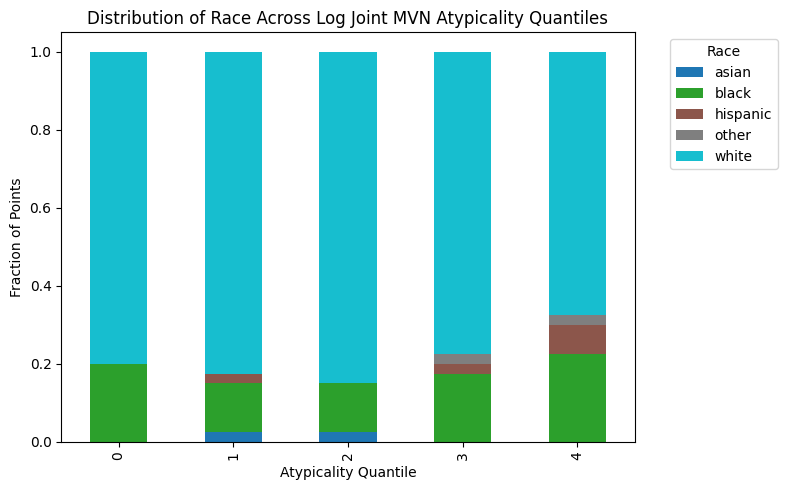

In [182]:
import matplotlib.pyplot as plt
import pandas as pd

num_quantiles = 5
df_test_full['quantile'] = pd.qcut(df_test_full['logjointmvn_score'], num_quantiles, labels=False)
ct = pd.crosstab(df_test_full['quantile'], df_test_full['race'], normalize='index')
ct.plot(kind='bar', stacked=True, colormap='tab10', figsize=(8,5))

plt.xlabel('Atypicality Quantile')
plt.ylabel('Fraction of Points')
plt.title('Distribution of Race Across Log Joint MVN Atypicality Quantiles')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


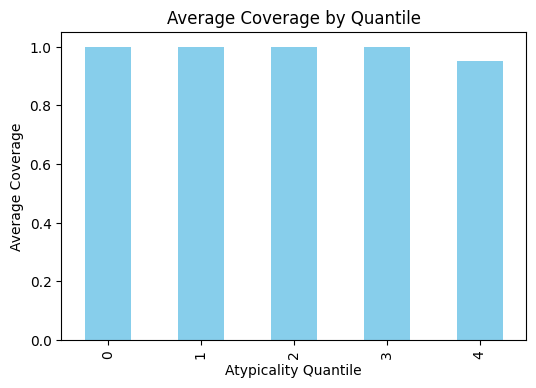

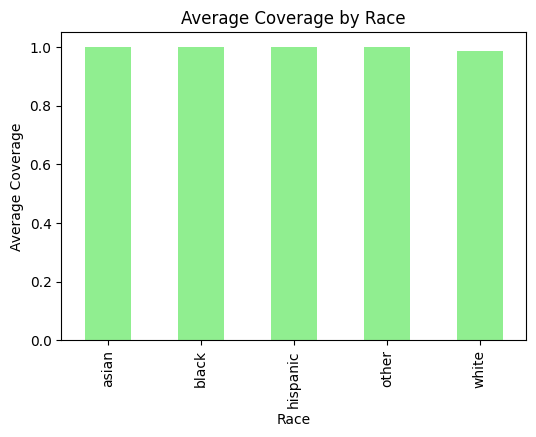

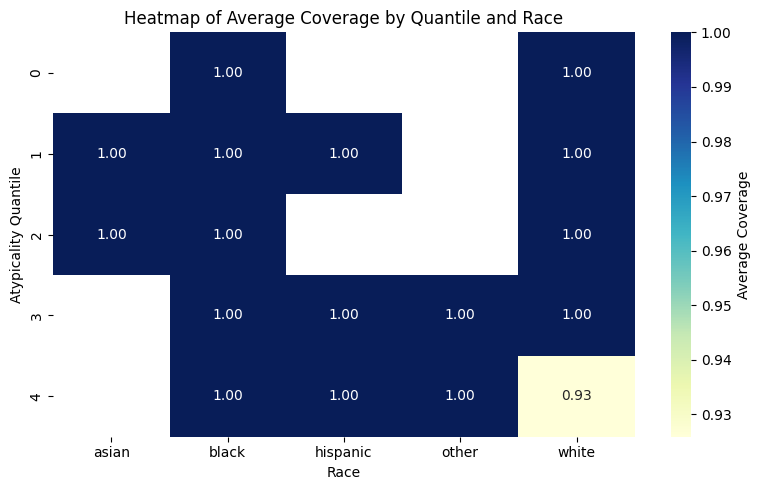

In [183]:
import seaborn as sns
# Avg coverage by quantile
df_test_full.groupby(['quantile'])['covered'].mean().plot(kind='bar', figsize=(6,4), color='skyblue')
plt.xlabel('Atypicality Quantile')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Quantile')
plt.show()

# By race
df_test_full.groupby('race')['covered'].mean().plot(kind='bar', figsize=(6,4), color='lightgreen')
plt.xlabel('Race')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Race')
plt.show()

# By race and quantile
coverage_q_r = df_test_full.groupby(['quantile', 'race'])['covered'].mean().unstack()

plt.figure(figsize=(8,5))
sns.heatmap(coverage_q_r, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Coverage'})

plt.xlabel('Race')
plt.ylabel('Atypicality Quantile')
plt.title('Heatmap of Average Coverage by Quantile and Race')
plt.tight_layout()
plt.show()